# GeMpy

In [1]:
import sys
sys.path.append("C:/Users/Alex/git/GeMpy")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

In [28]:
geo_data = gp.read_pickle("C:/Users/Alex/git/GeMpy/input_data/BasicFault.pickle")
geo_data.n_faults = 1

In [29]:
geo_data.interfaces.head()

,X,Y,Z,formation,series,order_series,isFault
0,800.0,1000.0,-1600.0,MainFault,fault,1,True
1,1200.0,1000.0,-400.0,MainFault,fault,1,True
2,1100.0,1000.0,-700.0,MainFault,fault,1,True
3,900.0,1000.0,-1300.0,MainFault,fault,1,True
4,1000.0,1000.0,-1000.0,MainFault,fault,1,True


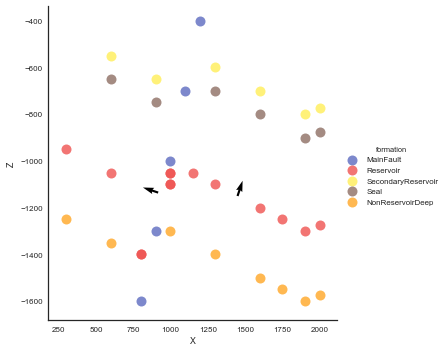

In [30]:
gp.plot_data(geo_data, direction='y')

In [31]:
# stdev for x,y,z interface coordinates
geo_data.interfaces['X_std'] = None
geo_data.interfaces['Y_std'] = None
geo_data.interfaces['Z_std'] = 100
geo_data.interfaces['dist_type'] = "Normal" # should be initially None
geo_data.interfaces['X_dist'] = None
geo_data.interfaces['Y_dist'] = None
geo_data.interfaces['Z_dist'] = None

#geo_data.foliations['X_std'] = None
#geo_data.foliations['Y_std'] = 0
#geo_data.foliations['Z_std'] = 0

In [32]:
geo_data.interfaces["Z_std"] = 500

In [33]:
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3],
                                   compile_theano=True)

I am in the setting
float32
I am here
[2, 2]


adding dataframe columns for uncertainty analysis

### Create pymc.Distribution objects for each stochastic value and put into df

In [34]:
def create_priors(data, data_ref):
    """
    data = interp_data.interpolator.pandas_rest_layer_points
    data_ref = interp_data.interpolator.ref_layer_points
    """
    X_priors = np.array([])
    Y_priors = np.array([])
    Z_priors = np.array([])

    # iterate over dataframe
    for i, row in data.T.iteritems():
        if math.isnan(row["X_std"]):
            X_priors = np.append(X_priors, row["X"])
        else:
            dist = pymc.Normal("X_" + str(i), row["X"], 1 / row["X_std"] ** 2)
            X_priors = np.append(X_priors, dist)

        if math.isnan(row["Y_std"]):
            Y_priors = np.append(Y_priors, row["Y"])
        else:
            dist = pymc.Normal("Y_" + str(i), row["Y"], 1 / row["Y_std"] ** 2)
            Y_priors = np.append(Y_priors, dist)

        if math.isnan(row["Z_std"]):
            Z_priors = np.append(Z_priors, row["Z"])
        else:
            dist = pymc.Normal("Z_" + str(i), row["Z"], 1 / row["Z_std"] ** 2)
            Z_priors = np.append(Z_priors, dist)
    
    # ///////////////////////////////////////////////////////////////////////////////////
    # take care of ref values
    for fmt in np.unique(data["formation"].values):
        f = np.where(data["formation"].values == fmt)[0]
        #print(fmt+":",f)
        #print(ref_z[f[0]:f[-1]+1])
        data_ref[:,0][f[0]:f[-1]+1] = X_priors[f[0]]
        data_ref[:,1][f[0]:f[-1]+1] = Y_priors[f[0]]
        data_ref[:,2][f[0]:f[-1]+1] = Z_priors[f[0]]
    
    # ///////////////////////////////////////////////////////////////////////////////////
    return X_priors, Y_priors, Z_priors, data_ref  #, index

In [35]:
X_priors, Y_priors, Z_priors, data_ref = create_priors(interp_data.interpolator.pandas_rest_layer_points, interp_data.interpolator.ref_layer_points)

### Create pymc.Model

In [36]:
@pymc.deterministic
def gempy_model(value=0, interp_data=interp_data,
          xp = X_priors, yp = Y_priors, zp = Z_priors, ref = data_ref):
    
    # set data to fixed and/or prior draws
    interp_data.interpolator.pandas_rest_layer_points["X"] = xp
    interp_data.interpolator.pandas_rest_layer_points["Y"] = yp
    interp_data.interpolator.pandas_rest_layer_points["Z"] = zp
    # set ref values accordingly
    interp_data.interpolator.ref_layer_points = data_ref
    # print(interp_data.interpolator.pandas_rest_layer_points["Z"].values)
    # compute model
    sol = gp.compute_model(interp_data)
    # return solution
    return sol

C:\Users\Alex\Anaconda3\lib\site-packages\pymc\Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


[3, 3]


In [37]:
# set number of iterations
iterations = 10

In [38]:
params = []
for p in X_priors:
    if type(p) != np.float64:
        params.append(p)
for p in Y_priors:
    if type(p) != np.float64:
        params.append(p)
for p in Z_priors:
    if type(p) != np.float64:
        params.append(p)
params.append(gempy_model)

# set model
pymc_model = pymc.Model(params)

### MCFS

In [39]:
MCFS_RUN = pymc.MCMC(pymc_model)
MCFS_RUN.sample(iter=iterations)

[3, 3]
 [-------          20%                  ] 2 of 10 complete in 2.7 sec[3, 3]
 [-----------      30%                  ] 3 of 10 complete in 5.6 sec[3, 3]
 [---------------  40%                  ] 4 of 10 complete in 8.4 sec[3, 3]
 [-----------------50%                  ] 5 of 10 complete in 11.1 sec[3, 3]
 [-----------------60%--                ] 6 of 10 complete in 13.9 sec[3, 3]
 [-----------------70%------            ] 7 of 10 complete in 16.6 sec[3, 3]
 [-----------------80%----------        ] 8 of 10 complete in 19.6 sec[3, 3]
 [-----------------90%--------------    ] 9 of 10 complete in 22.5 sec[3, 3]
 [-----------------100%-----------------] 10 of 10 complete in 25.4 sec[3, 3]
 [------------------110%-------------------] 11 of 10 complete in 28.5 sec

In [40]:
import matplotlib.pyplot as plt

In [41]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [49]:
def p(i):
    ax.imshow(MCFS_RUN.trace("gempy_model", chain=-1)[i][0].reshape(50,50,50)[:,24,:].T, origin="lower")

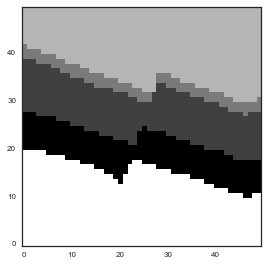

In [50]:
fig, ax = plt.subplots()
interact(p, i=widgets.IntSlider(min=0, max=9, step=1, value=0));